In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm.auto import tqdm
import seaborn as sns

In [2]:
class FuzzyLayer(nn.Module):
    """Custom Fuzzy Logic Layer using Gaussian Membership Functions"""

    def __init__(self, input_features, num_rules=5):
        super(FuzzyLayer, self).__init__()
        self.input_features = input_features
        self.num_rules = num_rules

        self.centers = nn.Parameter(torch.randn(num_rules, input_features))
        self.widths = nn.Parameter(torch.ones(num_rules, input_features))

    def forward(self, x):
        """
        Calculate membership degrees using Gaussian functions
        x shape: (batch_size, input_features)
        """
        membership_values = []

        for i in range(self.num_rules):
            diff = x - self.centers[i]
            membership = torch.exp(-torch.sum(diff ** 2 / (2 * self.widths[i] ** 2), dim=1, keepdim=True))
            membership_values.append(membership)

        fuzzy_output = torch.cat(membership_values, dim=1)
        return fuzzy_output

In [ ]:
class FuzzyCNN(nn.Module):
    """Fuzzy Convolutional Neural Network for Brain Tumor Classification"""

    def __init__(self, num_classes=4, num_fuzzy_rules=5, img_size=224):
        super(FuzzyCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        flatten_dim = img_size // (2**4) 
        self.flatten_size = 256 * flatten_dim * flatten_dim

        self.fc1 = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.fuzzy_layer = FuzzyLayer(input_features=512, num_rules=num_fuzzy_rules)

        self.fc2 = nn.Sequential(
            nn.Linear(512 + num_fuzzy_rules, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)

        x_dense = self.fc1(x)

        fuzzy_features = self.fuzzy_layer(x_dense)

        x_combined = torch.cat([x_dense, fuzzy_features], dim=1)

        x = self.fc2(x_combined)
        x = self.fc3(x)

        return x
class StandardCNN(nn.Module):
    """Standard Convolutional Neural Network (based on FuzzyCNN structure)"""

    def __init__(self, num_classes=4, img_size=224):
        super(StandardCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )

        flatten_dim = img_size // (2**4)
        self.flatten_size = 256 * flatten_dim * flatten_dim

        self.fc1 = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)

        x_dense = self.fc1(x)
        x = self.fc2(x_dense)
        x = self.fc3(x)

        return x

In [ ]:
def get_data_loaders(data_dir, batch_size=32, img_size=224, num_workers=2):
    """Prepare data loaders from pre-split training and testing folders."""

    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dir = os.path.join(data_dir, 'Training')
    test_dir = os.path.join(data_dir, 'Testing')

    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    
    return train_loader, test_loader, train_dataset.classes

def train_model(model, train_loader, num_epochs, device):
    """Trains the model for a specified number of epochs."""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {'train_loss': [], 'train_acc': []}

    for epoch in range(num_epochs):
        
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        pbar = tqdm(train_loader, desc='Training', leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

    print("\nTraining finished. Saving model...")
    torch.save(model.state_dict(), 'final_fuzzy_cnn_model.pth')
    return history

def train_model_cnn(model, train_loader, num_epochs, device):
    """Trains the model for a specified number of epochs."""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history = {'train_loss': [], 'train_acc': []}

    for epoch in range(num_epochs):
        
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        pbar = tqdm(train_loader, desc='Training', leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')

    print("\nTraining finished. Saving model...")
    torch.save(model.state_dict(), 'final_standard_cnn_model.pth')
    return history

def evaluate_model(model, test_loader, criterion, device):
    """Evaluates the model on the test set."""
    model.to(device)
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    test_loss = running_loss / total
    test_acc = 100 * correct / total
    return test_loss, test_acc, all_preds, all_labels

def plot_training_history(history):
    """Plot training metrics (modified to show only training data)"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history['train_acc'], label='Train Accuracy')
    axes[0].set_title('Model Accuracy'); axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy (%)')
    axes[0].legend(); axes[0].grid(True)
    axes[1].plot(history['train_loss'], label='Train Loss')
    axes[1].set_title('Model Loss'); axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss')
    axes[1].legend(); axes[1].grid(True)
    plt.tight_layout(); plt.savefig('training_history.png'); plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png'); plt.show()

In [5]:
DATA_DIR = '/home/kesavan/dl_fuzzy/brain-tumor-mri-dataset' 
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 4
NUM_FUZZY_RULES = 5
NUM_WORKERS = 0 

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

print('\nPreparing data...')
train_loader, test_loader, class_names = get_data_loaders(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    num_workers=NUM_WORKERS
)
print(f'Training samples: {len(train_loader.dataset)}')
print(f'Test samples: {len(test_loader.dataset)}')
print(f'Classes: {class_names}') 

print('\nCreating Fuzzy CNN model...\n')
model = FuzzyCNN(num_classes=NUM_CLASSES, num_fuzzy_rules=NUM_FUZZY_RULES, img_size=IMG_SIZE)

print(f'Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')


print('\n Creating Standard CNN model...\n')
cnn_model = StandardCNN(num_classes=NUM_CLASSES, img_size=IMG_SIZE)
print(f'Model Parameters: {sum(p.numel() for p in cnn_model.parameters() if p.requires_grad):,}')

print('\n Starting training for Standard CNN...')


Using device: cuda

Preparing data...
Training samples: 5712
Test samples: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

Creating Fuzzy CNN model...

Model Parameters: 27,005,092

 Creating Standard CNN model...

Model Parameters: 26,998,692

 Starting training for Standard CNN...


In [7]:
print('\nStarting training for FCNN...')
fcnn_history = train_model(model, train_loader, NUM_EPOCHS, device)
print('\nStarting training for CNN...')
cnn_history = train_model_cnn(cnn_model, train_loader, NUM_EPOCHS, device)



Starting training for FCNN...


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 1/20, Train Loss: 0.7763, Train Acc: 69.15%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 2/20, Train Loss: 0.5662, Train Acc: 77.80%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 3/20, Train Loss: 0.4855, Train Acc: 80.78%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 4/20, Train Loss: 0.4379, Train Acc: 82.51%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 5/20, Train Loss: 0.4135, Train Acc: 84.30%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 6/20, Train Loss: 0.3723, Train Acc: 85.64%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 7/20, Train Loss: 0.3594, Train Acc: 86.50%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 8/20, Train Loss: 0.3144, Train Acc: 87.66%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 9/20, Train Loss: 0.2957, Train Acc: 88.27%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 10/20, Train Loss: 0.2913, Train Acc: 89.01%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 11/20, Train Loss: 0.2678, Train Acc: 89.34%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 12/20, Train Loss: 0.2564, Train Acc: 90.25%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 13/20, Train Loss: 0.2363, Train Acc: 91.12%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 14/20, Train Loss: 0.2293, Train Acc: 91.65%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 15/20, Train Loss: 0.2060, Train Acc: 92.16%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 16/20, Train Loss: 0.2061, Train Acc: 92.28%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 17/20, Train Loss: 0.1961, Train Acc: 92.79%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 18/20, Train Loss: 0.1815, Train Acc: 93.56%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 19/20, Train Loss: 0.1686, Train Acc: 93.93%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 20/20, Train Loss: 0.1746, Train Acc: 93.26%

Training finished. Saving model...

Starting training for CNN...


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 1/20, Train Loss: 0.7561, Train Acc: 64.35%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 2/20, Train Loss: 0.5665, Train Acc: 72.50%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 3/20, Train Loss: 0.4943, Train Acc: 76.04%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 4/20, Train Loss: 0.4503, Train Acc: 77.76%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 5/20, Train Loss: 0.4038, Train Acc: 79.54%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 6/20, Train Loss: 0.3832, Train Acc: 80.80%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 7/20, Train Loss: 0.3417, Train Acc: 82.01%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 8/20, Train Loss: 0.3275, Train Acc: 82.48%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 9/20, Train Loss: 0.2983, Train Acc: 83.62%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 10/20, Train Loss: 0.2679, Train Acc: 85.25%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 11/20, Train Loss: 0.2487, Train Acc: 85.88%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 12/20, Train Loss: 0.2320, Train Acc: 86.23%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 13/20, Train Loss: 0.2018, Train Acc: 87.42%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 14/20, Train Loss: 0.2038, Train Acc: 87.44%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 15/20, Train Loss: 0.1928, Train Acc: 87.63%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 16/20, Train Loss: 0.1856, Train Acc: 88.31%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 17/20, Train Loss: 0.1897, Train Acc: 87.98%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 18/20, Train Loss: 0.1532, Train Acc: 89.63%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 19/20, Train Loss: 0.1515, Train Acc: 89.21%


Training:   0%|          | 0/179 [00:00<?, ?it/s]


Epoch 20/20, Train Loss: 0.1651, Train Acc: 89.15%

Training finished. Saving model...


In [8]:
def plot_confusion_matrixx(y_true, y_pred, classes):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [ ]:
def plot_comparison_history(fcnn_hist, cnn_hist):
    """Plot training metrics for both FCNN and CNN for comparison."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].plot(fcnn_hist['train_acc'], label='FCNN Train Accuracy', color='blue', marker='o')
    axes[0].plot(cnn_hist['train_acc'], label='Standard CNN Train Accuracy', color='red', marker='x')
    axes[0].set_title('Model Accuracy Comparison', fontsize=16)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True)
    axes[1].plot(fcnn_hist['train_loss'], label='FCNN Train Loss', color='blue', marker='o')
    axes[1].plot(cnn_hist['train_loss'], label='Standard CNN Train Loss', color='red', marker='x')
    axes[1].set_title('Model Loss Comparison', fontsize=16)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('training_comparison.png')
    plt.show()


Final Evaluation on the test set FCNN...


Testing:   0%|          | 0/41 [00:00<?, ?it/s]

Final Test Accuracy FCNN: 96.11%

Final Evaluation on the test set CNN...


Testing:   0%|          | 0/41 [00:00<?, ?it/s]

Final Test Accuracy CNN: 91.11%

Generating training history comparison plot...


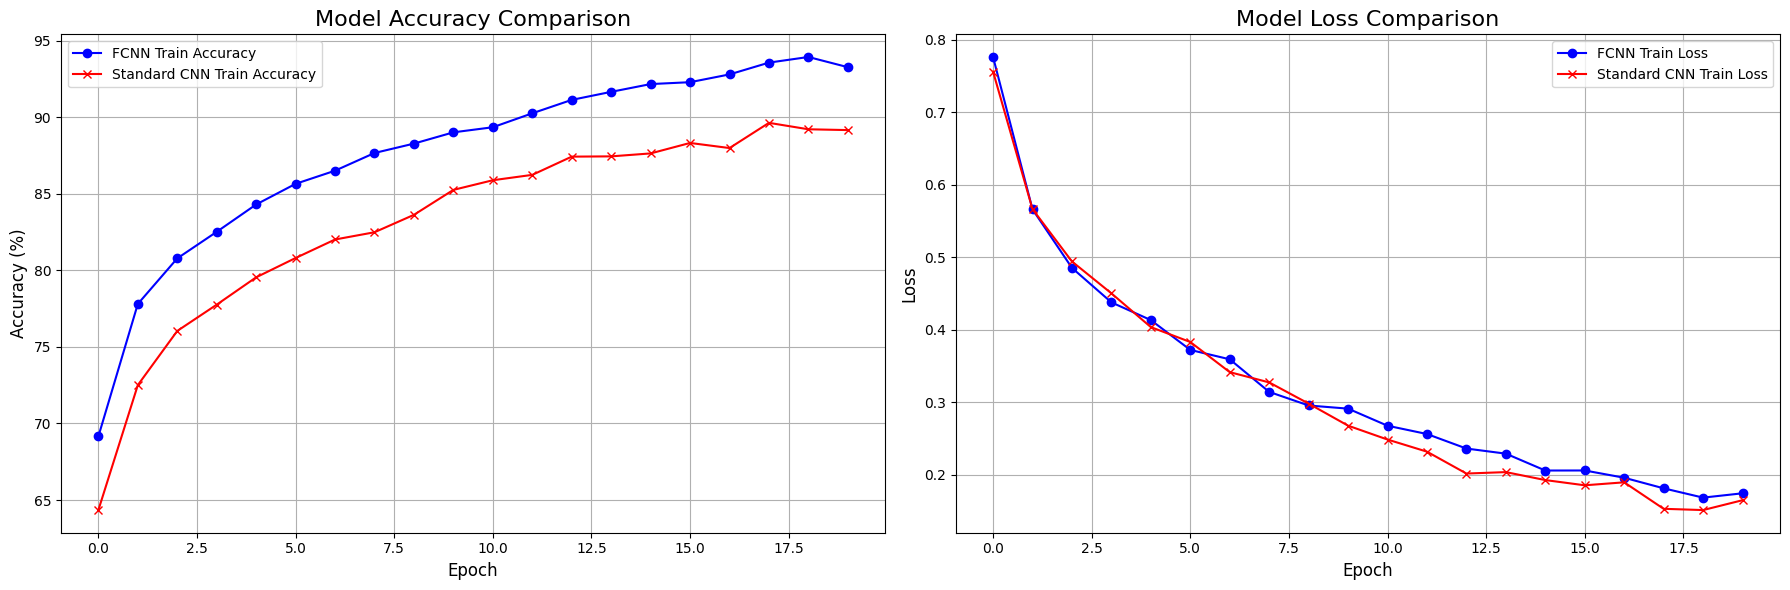

: 

In [ ]:

fcnn_model_eval = FuzzyCNN(num_classes=NUM_CLASSES, num_fuzzy_rules=NUM_FUZZY_RULES, img_size=IMG_SIZE)

fcnn_model_eval.load_state_dict(torch.load('final_fuzzy_cnn_model.pth'))

print('\nFinal Evaluation on the test set FCNN...')
criterion = nn.CrossEntropyLoss()

_, fcnn_test_acc, fcnn_y_pred, fcnn_y_true = evaluate_model(fcnn_model_eval, test_loader, criterion, device)
print(f'Final Test Accuracy FCNN: {fcnn_test_acc:.2f}%')

cnn_model_eval = StandardCNN(num_classes=NUM_CLASSES, img_size=IMG_SIZE)
cnn_model_eval.load_state_dict(torch.load('final_standard_cnn_model.pth'))

print('\nFinal Evaluation on the test set CNN...')
criterion = nn.CrossEntropyLoss()
_, cnn_test_acc, cnn_y_pred, cnn_y_true = evaluate_model(cnn_model_eval, test_loader, criterion, device)
print(f'Final Test Accuracy CNN: {cnn_test_acc:.2f}%') 

print("\nGenerating training history comparison plot...")
plot_comparison_history(fcnn_history, cnn_history)